In [23]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [195]:
mnist_data_train = torchvision.datasets.MNIST('./data/mnist', download=True, transform=torchvision.transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, transform=torchvision.transforms.ToTensor())
print(mnist_data_train.data.size())
print(mnist_data_test.data.size())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [196]:
trainloader = torch.utils.data.DataLoader(mnist_data_train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_data_test, batch_size=64, shuffle=True)

In [197]:
example = next(iter(trainloader))

In [198]:
def show_im_grid(images, labels):
  fig, ax = plt.subplots(4, 4)
  for i, a in enumerate(ax.flat):
    a.imshow(images[i])
    a.set_title(labels[i].item())
    a.set_axis_off()
  fig.tight_layout()

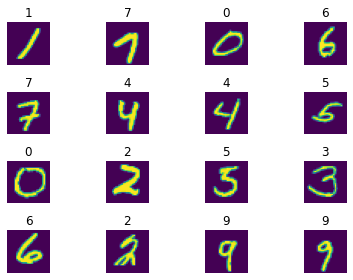

In [199]:
fig, ax = plt.subplots(4, 4)
for i, a in enumerate(ax.flat):
  a.imshow(example[0][i].squeeze())
  a.set_title(example[1][i].item())
  a.set_axis_off()
fig.tight_layout()

In [200]:
torch.nn.Flatten()(example[0][1]).shape

torch.Size([1, 784])

In [201]:
def log_standard_normal(x, reduction=None, dim=None):  
    PI = torch.from_numpy(np.asarray(np.pi))
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [202]:
def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
  PI = torch.from_numpy(np.asarray(np.pi))
  log_p = -0.5 * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
  if reduction == 'avg':
    return torch.mean(log_p, dim)
  elif reduction == 'sum':
    return torch.sum(log_p, dim)
  else:
    return log_p

In [203]:
class Encoder(torch.nn.Module):
  def __init__(self, latent_size):
    super(Encoder, self).__init__()
    self.flatten = torch.nn.Flatten()
    self.linear = torch.nn.Linear(28, 392)
    self.relu = torch.nn.LeakyReLU()
    self.linear2 = torch.nn.Linear(392, 392)
    self.relu2 = torch.nn.LeakyReLU()
    self.linear3 = torch.nn.Linear(392, 2 * latent_size)
    #self.mus = torch.nn.Linear(256, latent_size)
    #self.log_sigmas = torch.nn.Linear(256, latent_size)

  def forward(self, batch):
    out = self.flatten(batch)
    out = self.linear(batch)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu2(out)
    out = self.linear3(out)
    mu_e, log_var_e = torch.chunk(out, 2, dim=2)
    return mu_e, log_var_e

In [204]:
def reparam(mus, sigs):
    '''Reparametrization trick - get N(mu, sig) from mu, sig and N(0,1).'''
    epsilons = torch.randn_like(sigs)
    z = mus + epsilons * sigs

    return z

In [205]:
class Decoder(torch.nn.Module):
  def __init__(self, latent_dim, out_size=28):
    super(Decoder, self).__init__()
    self.linear1 = torch.nn.Linear(latent_dim, 392)
    self.relu = torch.nn.LeakyReLU()
    self.linear2 = torch.nn.Linear(392, 392)
    self.relu2 = torch.nn.LeakyReLU()
    self.linear3 = torch.nn.Linear(392, out_size*out_size)

  def forward(self, batch):
    out = self.linear1(batch)
    out = self.relu(out)
    out = self.linear2(out)
    out = self.relu2(out)
    out = self.linear3(out)

    return out

In [206]:
class FlowPrior(torch.nn.Module):
    def __init__(self, nets, nett, num_flows, D=2):
        super(FlowPrior, self).__init__()

        self.D = D

        self.t = torch.nn.ModuleList([nett() for _ in range(num_flows)])
        self.s = torch.nn.ModuleList([nets() for _ in range(num_flows)])
        self.num_flows = num_flows

    def coupling(self, x, index, forward=True):
        (xa, xb) = torch.chunk(x, 2, 1)
        
        
        s = self.s[index](xa)
        t = self.t[index](xa)

        if forward:
            #yb = f^{-1}(x)
            yb = (xb - t) * torch.exp(-s)
        else:
            #xb = f(y)
            yb = torch.exp(s) * xb + t

        return torch.cat((xa, yb), 1), s

    def permute(self, x):
        return x.flip(1)

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in range(self.num_flows):
            z, s = self.coupling(z, i, forward=True)
            z = self.permute(z)
            log_det_J = log_det_J - s.sum(dim=1)

        return z, log_det_J

    def f_inv(self, z):
        x = z
        for i in reversed(range(self.num_flows)):
            x = self.permute(x)
            x, _ = self.coupling(x, i, forward=False)

        return x

    def sample(self, batch_size):
        z = torch.randn(batch_size, self.D)
        x = self.f_inv(z)
        return x.view(-1, self.D)

    def log_prob(self, x):
        z, log_det_J = self.f(x)
        log_p = (log_standard_normal(z) + log_det_J.unsqueeze(1))
        return log_p

In [207]:
class VAE(torch.nn.Module):
  def __init__(self, prior, latent_dim):
    super(VAE, self).__init__()
    self.encoder = Encoder(latent_size=latent_dim)
    self.decoder = Decoder(latent_dim=latent_dim)
    self.prior = prior
    self.z = []

  def reparam(self, mus, sigs):
    '''Reparametrization trick - get N(mu, sig) from mu, sig and N(0,1).'''
    epsilons = torch.randn_like(sigs)
    z = mus + epsilons * sigs
    
    return z

  def forward(self, batch):
    mus, log_sigmas = self.encoder(batch)
    self.mus = mus
    self.sigmas = torch.exp(log_sigmas)
    z = self.reparam(mus, self.sigmas)
    self.z = z
    out = self.decoder(z)
    return torch.sigmoid(out)

In [208]:
def train(vae, trainloader, epochs=3, lr=0.001, debug_with_images=False, crit=None):
  if crit == None:
    criterion = torch.nn.MSELoss()#(reduction='sum')
  else:
    criterion = crit
  optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
  total_loss = []
  for epoch in range(epochs):
    print('Epoch ', epoch)
    rec_losses = []
    klds = []
    losses = []
    for traindata, label in trainloader:
      traindata.to(device)
      label.to(device)
      result = vae(traindata)
      #rec_loss = criterion(result.reshape(traindata.shape), traindata)
      #kld = kl_divergence(vae.mus, vae.sigmas)
      #print(vae.mus, vae.sigmas)
      kl = (vae.prior.log_prob(vae.z) - log_normal_diag(vae.z, vae.mus, vae.sigmas)).sum(-1)
      #kl = vae.prior.log_prob(vae.z)
      #kl2 = - log_normal_diag(vae.z, vae.mus, vae.sigmas).sum(-1)
      #print(criterion(result.reshape(traindata.shape), traindata))
      loss = criterion(result.reshape(traindata.shape), traindata) + kl # + rec_loss + kld
      #print(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      #rec_losses.append(rec_loss.detach())
      #klds.append(kld.detach())
      losses.append(loss.detach())
    if debug_with_images:
      plt.imshow(vae.decoder(torch.randn((1, vae.decoder.linear.in_features))).squeeze().permute(1,2,0).detach())
      plt.show()
    print('Loss: ', np.sum(losses))#, ' KLD: ', klds[-1])
    total_loss.append(np.sum(losses))
    

  return total_loss, vae

In [209]:
#D = 64   # input dimension
L = 2 # number of latents
M = 392  # the number of neurons in scale (s) and translation (t) nets

num_epochs = 100 # max. number of epochs

num_flows = 3

# scale (s) network
nets = lambda: torch.nn.Sequential(torch.nn.Linear(L // 2, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, L // 2), torch.nn.Tanh())

# translation (t) network
nett = lambda: torch.nn.Sequential(torch.nn.Linear(L // 2, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, M), torch.nn.LeakyReLU(),
                                torch.nn.Linear(M, L // 2))

prior = FlowPrior(nets, nett, num_flows=num_flows, D=L)
vae = VAE(prior, 2)

vae.to(device)

VAE(
  (encoder): Encoder(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=28, out_features=392, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=392, out_features=392, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (linear3): Linear(in_features=392, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=392, bias=True)
    (relu): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=392, out_features=392, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
    (linear3): Linear(in_features=392, out_features=784, bias=True)
  )
  (prior): FlowPrior(
    (t): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=1, out_features=392, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): Linear(in_features=392, out_features=392, bias=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Linear(in_features=392

In [210]:
losses, _ = train(vae, trainloader, epochs=num_epochs)

Epoch  0


RuntimeError: ignored